In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV

In [168]:
for i, col in enumerate([c for c in df.columns if 'pre_' in c]):
    print(i, col, df.loc[df[col] == 1, col].count())

0 pre_京都府 490
1 pre_佐賀県 14
2 pre_兵庫県 856
3 pre_北海道 92
4 pre_千葉県 286
5 pre_和歌山県 33
6 pre_埼玉県 442
7 pre_大阪府 2876
8 pre_奈良県 28
9 pre_宮城県 140
10 pre_富山県 126
11 pre_山口県 36
12 pre_山形県 22
13 pre_山梨県 70
14 pre_岐阜県 181
15 pre_岡山県 70
16 pre_広島県 282
17 pre_徳島県 19
18 pre_愛媛県 33
19 pre_愛知県 1182
20 pre_新潟県 288
21 pre_東京都 12623
22 pre_栃木県 112
23 pre_沖縄県 20
24 pre_滋賀県 62
25 pre_熊本県 27
26 pre_石川県 117
27 pre_神奈川県 1371
28 pre_福井県 69
29 pre_福岡県 334
30 pre_福島県 36
31 pre_群馬県 169
32 pre_茨城県 30
33 pre_長野県 198
34 pre_静岡県 357
35 pre_香川県 105
36 pre_高知県 25
37 pre_鳥取県 6


In [8]:
# データの読込
path = '../../data/Analysis/analysis_data_three.csv'
df = pd.read_csv(path, encoding='cp932', header=0)

# BCPを作った年以降のレコードは落とす
#df = df[(df['BCP'] == 0) | ((df['BCP_obs'] == 1) & (df['BCP'] == 1))]

# 2020年までのデータに絞り込み
# df = df[df['year'] <= 2020]

# 共変量Xを選択
# 分析するアウトカムと、（BCPの傾向スコアを算出するための）説明変数、群別変数の定義
X_cols = [
    'lag_yj_total_assets',
    'lag_yj_operating_cash_flow', 'lag_yj_ros', 'lag_yj_cash_deposit_ratio',
    'lag_yj_leverage', 'lag_yj_stock_price_growth',
    'lag_yj_net_profit_growth', 'lag_yj_firm_age',
    'lag_yj_fixed_assets_ratio', 'lag_yj_extraordinary_loss',
    'lag_yj_foreign_stock_ratio',
    'turnover', 'lag_turnover', 'lag_turnover_cumsum', 'sensitivity_analysis',
    'lag_sensitivity_analysis', 'lag_sensitivity_analysis_cumsum'
    ]
dummies = [c for c in df.columns if 'acc_' in c or 'ind_' in c or 'pre_' in c or 'yer_' in c]
for d_col in dummies:
    df[d_col] = df[d_col].apply(lambda x: np.nan if x == 0 else x)
df.dropna(axis=1, how='all', inplace=True)
df.fillna(value=0, inplace=True)
dummies = [c for c in df.columns if 'acc_' in c or 'ind_' in c or 'pre_' in c or 'yer_' in c]
for d_col in range(2007, 2009):
    d_col = 'yer_' + str(d_col)
    dummies.remove(d_col)
for d_col in ['pre_山口県']:
    dummies.remove(d_col)
X_cols = X_cols + dummies
X = df[X_cols]

# 群別変数Zを選択
Z = df['BCP']

# 傾向スコアの推定
const = sm.add_constant(X) # 切片の追加
logit_model = sm.Logit(endog=Z, exog=const) # ロジスティック回帰
logit_res = logit_model.fit()

ps = logit_res.predict(const)
df['ps'] = ps
print('AUC = {:.3f}'.format(roc_auc_score(y_true=Z, y_score=ps)))
logit_res.summary()

         Current function value: 0.382630
         Iterations: 35
AUC = 0.784


C:\Users\koeci\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    BCP   No. Observations:                23330
Model:                          Logit   Df Residuals:                    23245
Method:                           MLE   Df Model:                           84
Date:                Mon, 15 Nov 2021   Pseudo R-squ.:                  0.1729
Time:                        13:18:30   Log-Likelihood:                -8926.8
converged:                      False   LL-Null:                       -10793.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -2.7172      0.427     -6.371      0.000      -3.553      -1.881
lag_yj_total_assets                 0.7141      0.042     17.165      0.000       0.633       0.796
lag_yj_operating_cash_flow         -0.0948      0.019     -5.083      0.000      -0.131      -0.058
lag_yj_ros                         -0.0238      0.023     -1.043      0.297      -0.068       0.021
lag_yj_cash_deposit_ratio           0.0108      0.024      0.443      0.658      -0.037       0.059
lag_yj_leverage                    -0.0397      0.030     -1.329      0.184      -0.098       0.019
lag_yj_stock_price_growth           0.0253      0.024      1.071      0.284      -0.021       0.072
lag_yj_net_profit_growth           -0.0081      0.021     -0.392      0.695      -0.049       0.032
lag_yj_firm_age                     0.0155      0.023      0.688      0.491      -0.029       0.060
lag_yj_fixed_assets_ratio          -0.1725      0.032     -5.380      0.000      -0.235      -0.110
lag_yj_extraordinary_loss           0.0545      0.026      2.060      0.039       0.003       0.106
lag_yj_foreign_stock_ratio         -0.1129      0.032     -3.480      0.001      -0.177      -0.049
turnover                            0.0308      0.059      0.526      0.599      -0.084       0.146
lag_turnover                       -0.0677      0.062     -1.084      0.279      -0.190       0.055
lag_turnover_cumsum                 0.0831      0.023      3.579      0.000       0.038       0.129
sensitivity_analysis                0.1018      0.153      0.665      0.506      -0.198       0.402
lag_sensitivity_analysis           -0.0649      0.262     -0.248      0.804      -0.579       0.449
lag_sensitivity_analysis_cumsum     0.0133      0.069      0.194      0.846      -0.121       0.148
acc_SEC                            -0.3208      0.264     -1.217      0.224      -0.837       0.196
acc_日本                             -0.4183      0.191     -2.187      0.029      -0.793      -0.043
ind_不動産                            -0.5177      0.290     -1.784      0.074      -1.086       0.051
ind_医薬品                            -0.5402      0.291     -1.857      0.063      -1.110       0.030
ind_商社・卸売                           0.0410      0.253      0.162      0.872      -0.456       0.538
ind_小売                             -1.1379      0.276     -4.122      0.000      -1.679      -0.597
ind_建設・資材                           0.0568      0.252      0.226      0.822      -0.436       0.550
ind_情報通信・サービスその他                    0.2148      0.250      0.860      0.390      -0.274       0.704
ind_機械                             -0.4670      0.255     -1.829      0.067      -0.967       0.033
ind_素材・化学                          -0.1728      0.251     -0.687      0.492      -0.666       0.320
ind_自動車・輸送機                        -0.4294      0.264     -1.629      0.103      -0.946       0.087
ind_運輸・物流                          -0.021

BCP
0.0    AxesSubplot(0.125,0.125;0.775x0.755)
1.0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: ps, dtype: object

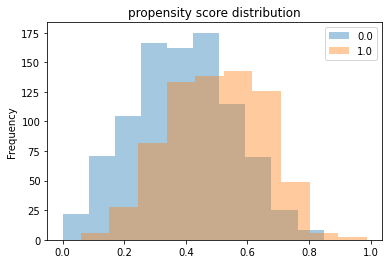

In [9]:
# 傾向スコアの分布を確認
ps_dist = df.loc[(0 <= df['ps']) & (df['ps'] <= 1) & (df['year'] == 2021), ['ps', 'BCP']]
ps_dist = ps_dist.groupby('BCP')['ps']
ps_dist
ps_dist.plot.hist(alpha=0.4, title=f'propensity score distribution', legend=True)

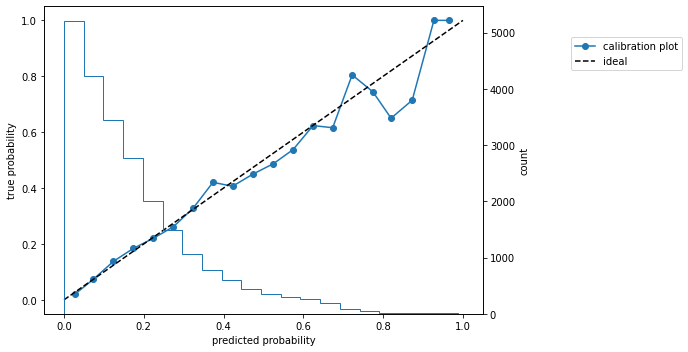

In [10]:
def calibration_plot(y_true, y_prob):
    fig, ax = plt.subplots(figsize=(10, 5))
    prob_true, prob_pred = calibration_curve(y_true=y_true, y_prob=y_prob, n_bins=20)
    ax.plot(prob_pred, prob_true, marker='o', label='calibration plot')
    ax.plot([0,1], [0,1], linestyle='--', color='black', label='ideal')
    ax.legend(bbox_to_anchor=(1.2, 0.9), loc='upper left', borderaxespad=0)
    ax.set_xlabel('predicted probability')
    ax.set_ylabel('true probability')

    ax2 = ax.twinx()
    ax2.hist(y_prob, bins=20, histtype='step', rwidth=0.9)
    ax2.set_ylabel('count')
    plt.tight_layout()
    plt.show()

calibration_plot(y_true=Z, y_prob=df['ps'])

### Logistic Regression

0.8356622374624947
[0.04574822 0.04296581 0.05386533 ... 0.05576852 0.14821131 0.16325622]
AUC = 0.784


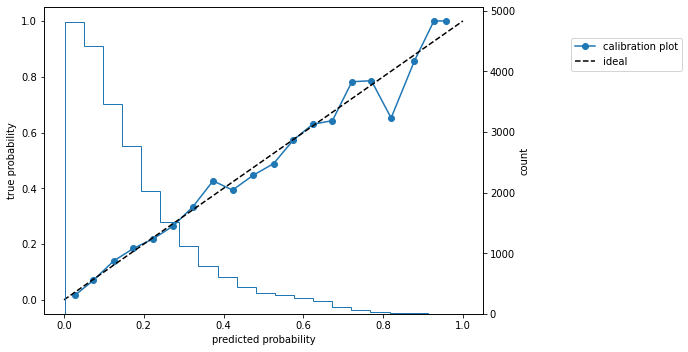

[[18776   488]
 [ 3346   720]]


In [11]:
rs = 1234
clf = LogisticRegression(max_iter=1000, random_state=rs)
clf.fit(X, Z)
pred = clf.predict_proba(X)[:, 1]
print(clf.score(X, Z))
print(pred)
print('AUC = {:.3f}'.format(roc_auc_score(y_true=Z, y_score=pred)))
calibration_plot(y_true=Z, y_prob=pred)
print(confusion_matrix(y_true=Z, y_pred=clf.predict(X)))

## Calcurate ATT using propensity score

In [168]:
df.reset_index(inplace=True)
ps = clf.predict_proba(X)[:, 1]
sample_size = len(df[df['BCP'] == 1])
ATT_list = []
y = df['yj_sales_growth']
Z = df['BCP']

for i in range(5000):
    idx1 = pd.Series(df.loc[df['BCP'] == 1, 'yj_sales_growth'].index).sample(n=sample_size, replace=True, random_state=i)
    idx0 = pd.Series(df.loc[df['BCP'] == 0, 'yj_sales_growth'].index).sample(n=sample_size, replace=True, random_state=i)
    
    Z_tmp = np.r_[Z[idx1], Z[idx0]]
    y_tmp = np.r_[y[idx1], y[idx0]]
    ps_tmp = np.r_[ps[idx1], ps[idx0]]
    w01_tmp = (1 - Z_tmp) * ps_tmp / (1 - ps_tmp)

    E1 = np.mean(y_tmp[Z_tmp == 1])
    E0 = np.sum(y_tmp * w01_tmp) / np.sum(w01_tmp)
    ATT = E1 - E0
    ATT_list.append(ATT)

print('ATT = {:.3f} ± {:.3f} (s.d.={:.3f})'.format(np.nanmean(ATT_list, ), np.nanstd(ATT_list)*1.96, np.std(ATT_list)))

ATT = -0.056 ± 0.285 (s.d.=0.145)


## Machine Learning

### Random Forest

0.5729166666666666
[0.21298991 0.15484623 0.19383292 ... 0.27890369 0.12679419 0.07201437]
AUC = 0.757


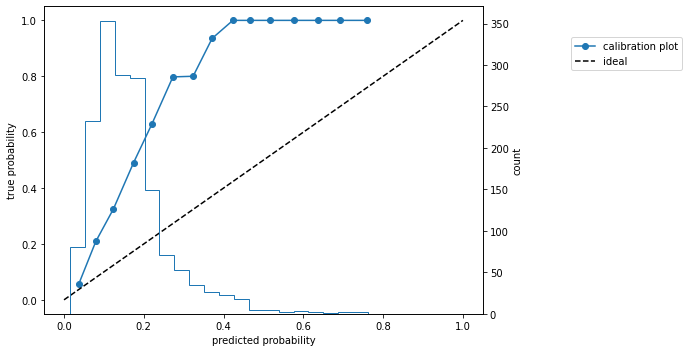

In [12]:
rs = 1234
y = df['BCP']
X_train = df.loc[df['year'] <= 2020, X_cols]
X_test = df.loc[df['year'] == 2021, X_cols]
y_train = df.loc[df['year'] <= 2020, 'BCP']
y_test = df.loc[df['year'] == 2021, 'BCP']
clf = RandomForestClassifier(random_state=rs)
clf.fit(X_train, y_train)
# pred = clf.predict_proba(X_test)[:, 1]
# print(clf.score(X_test, y_test))
# print(pred)

# Random Forest: 補正前のcalibration curve
# print('AUC = {:.3f}'.format(roc_auc_score(y_true=y_test, y_score=pred)))
# calibration_plot(y_true=y_test, y_prob=pred)

calibrated_clf = CalibratedClassifierCV(clf, method='isotonic', cv=5)
calibrated_clf.fit(X_train, y_train)
calibrated_pred = calibrated_clf.predict_proba(X_test)[:, 1]
print(calibrated_clf.score(X_test, y_test))
print(calibrated_pred)

# Random Forest: 補正後のcalibration curve
print('AUC = {:.3f}'.format(roc_auc_score(y_true=y_test, y_score=calibrated_pred)))
calibration_plot(y_true=y_test, y_prob=calibrated_pred)

## 他の機械学習

### Gradient Boosting (勾配ブースティング)

0.8366909558508359
[0.05175444 0.13056198 0.07097935 ... 0.03835374 0.21062393 0.50647155]
0.8368338334047721
[0.01690053 0.13007915 0.03262377 ... 0.01548639 0.21870259 0.53890636]
AUC = 0.786


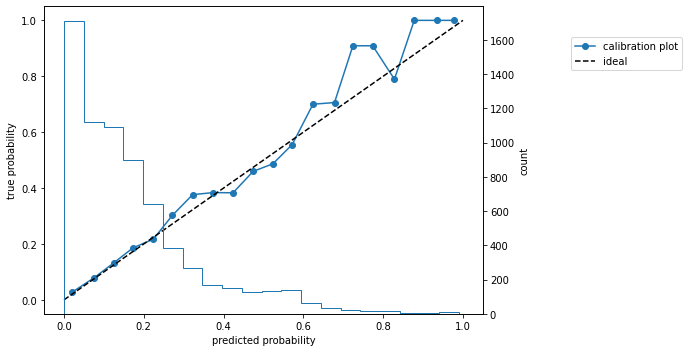

In [13]:
rs = 1234
y = df['BCP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
clf = GradientBoostingClassifier(random_state=rs)
clf.fit(X_train, y_train)
pred = clf.predict_proba(X_test)[:, 1]
print(clf.score(X_test, y_test))
print(pred)

calibrated_clf = CalibratedClassifierCV(clf, method='isotonic', cv=5)
calibrated_clf.fit(X_train, y_train)
calibrated_pred = calibrated_clf.predict_proba(X_test)[:, 1]
print(calibrated_clf.score(X_test, y_test))
print(calibrated_pred)

# Gradinet Boosting: 補正後のcalibration curve
print('AUC = {:.3f}'.format(roc_auc_score(y_true=y_test, y_score=calibrated_pred)))
calibration_plot(y_true=y_test, y_prob=calibrated_pred)

### LightGBM

0.8454064866409488
AUC = 0.821


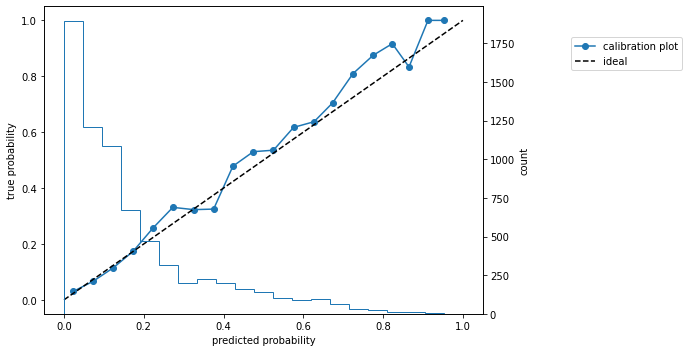

In [214]:
rs = 1234
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
model = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary')
model.fit(X_train, y_train)
lgb_pred = model.predict_proba(X_test)[:, 1]

# LightGBM: 補正前のcalibration curve
# print('AUC = {:.3f}'.format(roc_auc_score(y_true=y_test, y_score=lgb_pred)))
# calibration_plot(y_true=y_test, y_prob=lgb_pred)

# LightGBM: 補正後のcalibration curve
lgb_calibrated_model = CalibratedClassifierCV(model, method='isotonic', cv=5)
lgb_calibrated_model.fit(X_train, y_train)
lgb_calibrated_pred = lgb_calibrated_model.predict_proba(X_test)[:, 1]
print(lgb_calibrated_model.score(X_test, y_test))
print('AUC = {:.3f}'.format(roc_auc_score(y_true=y_test, y_score=lgb_calibrated_pred)))
calibration_plot(y_true=y_test, y_prob=lgb_calibrated_pred)

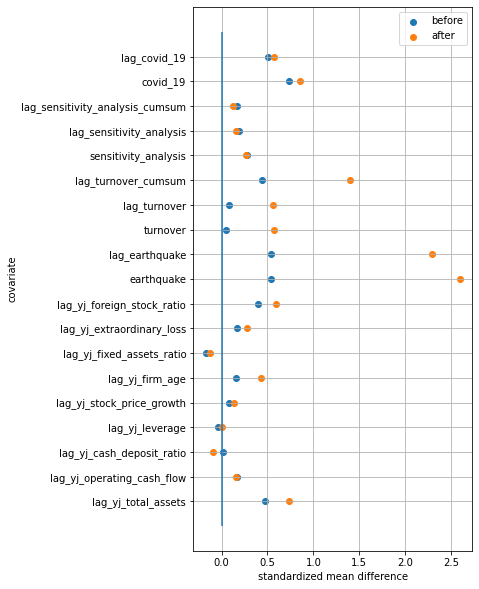

In [215]:
def standardized_mean_difference(X1, X0): # SMDを計算する関数
    N1 = len(X1)
    N0 = len(X0)
    s_pool = ((N1-1)*np.var(X1)+(N0-1)*np.var(X0))/(N1+N0-2)

    return (np.mean(X1)-np.mean(X0))/np.sqrt(s_pool)

def smd_on_the_treated(X, Z, ps): # 傾向スコアを用いた調整前後のSMDを計算する関数
    X1 = X[Z==1]
    X0 = X[Z==0]
    ps0 = ps[Z==0]
    X10 = X0*ps0/(1-ps0)

    smd_before = standardized_mean_difference(X1, X0)
    smd_after = standardized_mean_difference(X1, X10)

    return smd_before, smd_after

# 各共変量について、傾向スコアを用いた調整前後のSMDを計算する
smd_list = []
for name in X.columns:
    smd_before, smd_after = smd_on_the_treated(X=X[name], Z=y, ps=ps)
    smd_list.append([name, smd_before, smd_after])
smd_df = pd.DataFrame(smd_list, columns=['covariate', 'SMD(before)', 'SMD(after)'])

# 各共変量について、傾向スコアを用いた調整前後のSMDをプロットする（love plotを作成する）
plt.figure(figsize=(5, 10))
plt.scatter(smd_df['SMD(before)'], smd_df['covariate'], label='before')
plt.scatter(smd_df['SMD(after)'], smd_df['covariate'], label='after')
plt.vlines([0], ymin=-1, ymax=X.shape[1])
plt.legend()
plt.xlabel('standardized mean difference')
plt.ylabel('covariate')
plt.grid(True)
plt.show()